In [8]:
from sklearn.decomposition import PCA
from scipy import io
import numpy as np

In [9]:
data_address = '/mnt/data/leevi/IndianPines/Indian_pines_corrected.mat'

In [16]:
data = io.loadmat(data_address)

In [21]:
data_np = data['indian_pines_corrected']

In [23]:
data_np.shape

(145, 145, 200)

PCA(n_components=20)

In [106]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.68493799 0.23531371 0.01496355 0.00821542 0.00695011 0.00517011
 0.00399681 0.0036236  0.00307127 0.00293212 0.00267353 0.0024923
 0.00224688 0.00189389 0.00169434 0.00156043 0.00153162 0.00135011
 0.00100133 0.00092481]
[750586.00933965 439945.06443413 110941.01134558  82203.36462245
  75608.52371839  65211.56208324  57336.58494559  54593.98226876
  50261.34595883  49109.51297753  46894.00765182  45276.73336585
  42989.77019021  39468.61218015  37331.42727605  35825.92065672
  35493.64338204  33324.11904142  28698.78009495  27580.36943422]


In [107]:
pca.components_.shape

(20, 200)

In [56]:
import matplotlib.pyplot as plt

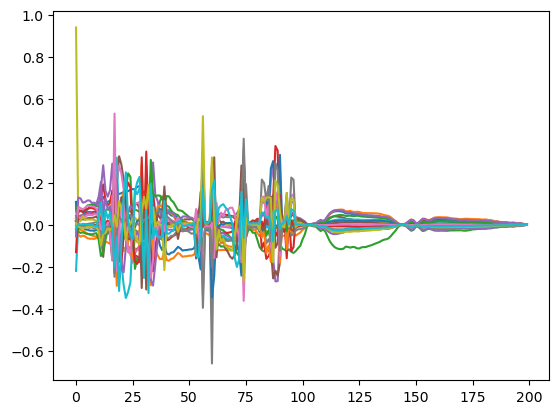

In [64]:
import scipy.sparse.linalg as la
import xarray as xr
def fva(data, em, p, orig_shape):
        '''
        Filter vector algorithm
        Jeffrey H. Bowles, Peter J. Palmadesso, John A. Antoniades,
        Mark M. Baumback, Lee J. Rickard,
        "Use of filter vectors in hyperspectral data analysis,"
        Proc. SPIE 2553, Infrared Spaceborne Remote Sensing III,
        (29 September 1995);
        '''
        # print('done')
        p_1 = data.shape[0]
        p_2 = em.shape[0]

        # print('done')
        P = np.matmul(
            np.linalg.pinv(np.matmul(np.transpose(em), em)),
            np.transpose(em)
        )

        # print('done')
        # print(P.shape)
        # print(data.shape)
        ab_maps = np.matmul(P, data)

        ab_maps = np.transpose(ab_maps).reshape(orig_shape[0], orig_shape[1], p) ## FIks tis

        # print('done')
        return ab_maps

def vca(ds, n_endmembers):
    '''
    vertex component analysis
    Nascimento, J. M., & Dias, J. M. (2005).
    Vertex component analysis: A fast algorithm to unmix hyperspectral data.
    IEEE transactions on Geoscience and Remote Sensing, 43(4), 898-910.
    :param: ds: xarray dataset following fpipy convention
    :param: n_endmembers: number of endmembers to be searched
    :param: rad_or_refl: 'rad' for radiance, 'refl' for reflectance
    :param: use_bands: a list containing all bands you want to use. comma as a separator,
                feel free to use numpy like indexing in the mix, for example:
                1,2,3:6,7:20:4,21,30
    :param crop: x_min:x_max, y_min:y_max OR :,y_min:,y_max OR x_min:x_max,: OR :,:
    :return: xarray dataset containing results and matplotlib plot of the results.
    '''
    orig_shape = ds.shape
    data = ds.reshape(-1, ds.shape[-1]).T
    pixels = data.shape[1]
    bands = data.shape[0]
    p = int(n_endmembers)
    # """
    CovMat = np.divide(np.matmul(data, data.T), pixels)
    [U, S, VT] = la.svds(CovMat, k=p)
    X = np.matmul(np.transpose(U), data)
    X_mean = np.mean(X, axis=1)
    Y = np.divide(X, np.matmul(np.transpose(X), X_mean))

    eu = np.zeros((1, p))
    eu[0, p - 1] = 1

    A = np.zeros((p, p))
    A[:, 0] = eu

    I = np.eye(p)
    idx = np.zeros((p, 1))
    em = np.zeros((bands, p))

    for ik in range(p):
        w = np.random.rand(p, 1)
        tmp = np.matmul(I - np.matmul(A, np.linalg.pinv(A)), w)
        f = tmp / np.linalg.norm(tmp)
        v = np.matmul(np.transpose(f), Y)
        k = np.argmax(np.abs(v))
        A[:, ik] = Y[:, k]
        idx[ik] = k
        em[:, ik] = np.matmul(U, X[:, k])

    ab_maps = fva(data, em, p, orig_shape)
    # print(em.shape)
    # print(list(range(p)))
    # print(indices)
    # print(ab_maps.shape)
    # print(em.shape)
    # print(idx.squeeze().reshape(-1))
    ret_ds = xr.Dataset({'ab_maps': (('x', 'y', 'endmember'), ab_maps),
                         'em': (('band', 'endmember'), em),
                         'idx': (('endmember'), idx.squeeze().reshape(-1))},
                        coords={'x': range(orig_shape[0]),
                                'y': range(orig_shape[1]),
                                'endmember':range(p),
                                'band':range(orig_shape[-1])})
    return ret_ds


In [120]:
a = vca(data_np, 2, )

In [121]:
len(a.em.T)

2

In [122]:
pca = PCA(n_components=2)
pca.fit(data_np.reshape(-1,200))

PCA(n_components=2)

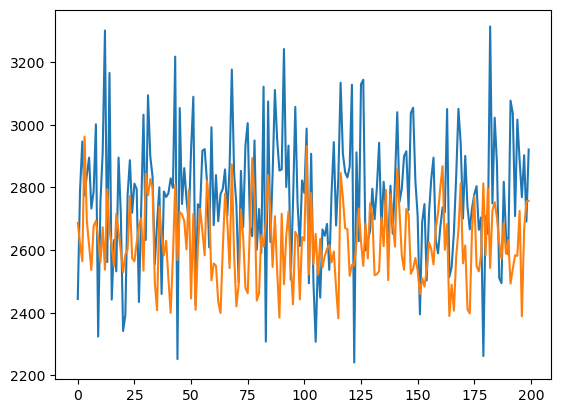

In [123]:
for i in a.em.T:
    plt.plot(i)

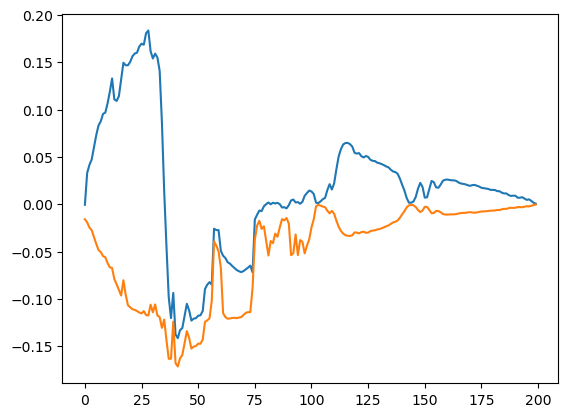

In [124]:
for i in pca.components_:
    plt.plot(i)

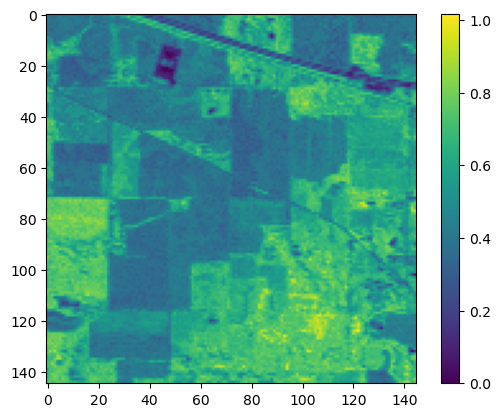

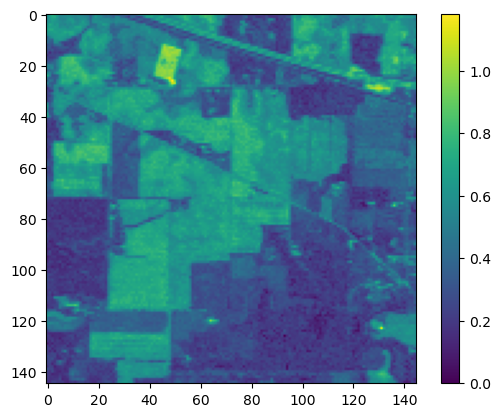

In [125]:
for i in a.endmember:
    plt.imshow(a.ab_maps[:,:,i])
    plt.colorbar()
    plt.show()

In [128]:
data_pca = pca.transform(data_np.reshape(-1, 200)).reshape((145,145,-1))
data_pca.shape

(145, 145, 2)

In [130]:
len(data_pca)

145

0.0 1.0


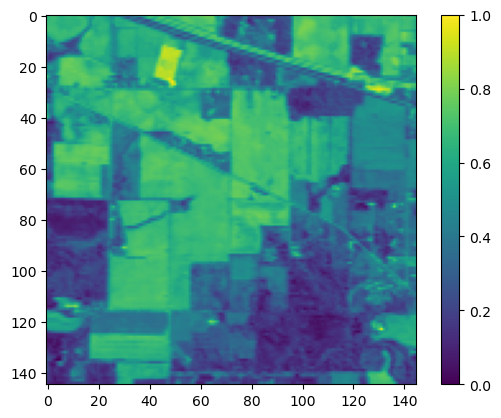

0.0 1.0


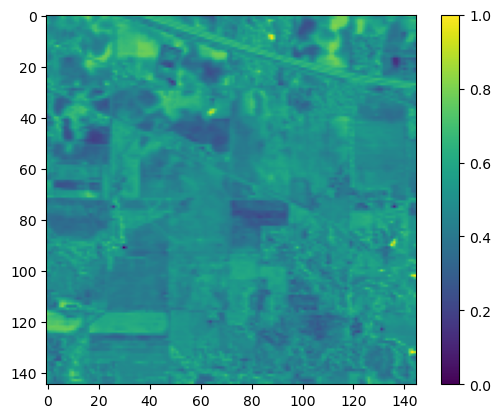

In [132]:
aa = data_pca
aa = (aa - np.min(aa, axis=(0,1))) / (np.max(aa, axis=(0,1)) - np.min(aa, axis=(0,1)))
for i in range(2):
    print(np.min(aa[:,:,i]), np.max(aa[:,:,i]))
    plt.imshow(aa[:,:,i])
    plt.colorbar()
    plt.show()

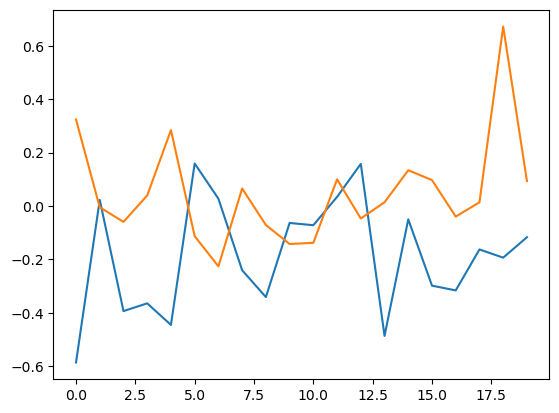

In [92]:
plt.plot(aa[100,100])
plt.plot(a.ab_maps[100,100])